# Tutorial

## Learning unbinned observables

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/ML4EFT/blob/gh-pages/docs/sphinx/source/installation/training.ipynb)

The goal of this tutorial is to demonstrate and to give a handle on how to obtain unbinned multivariate observables from machine learning. We do this by considering inclusive top quark pair production at the particle level i.e. including top quark
decays in the dilepton channel: $p p \rightarrow t \bar{t}, t \bar{t} \rightarrow b \bar{b} \ell^{+} \ell^{-} \nu_{\ell} \bar{\nu}_{\ell}$, at the LHC 14 TeV as an example. We focus on the following two dimension-six operators that modifiy top-quark pair production:

$$ \begin{align}\mathcal{O}_{tG} &= ig_s(\bar{Q}\tau^{\mu\nu}T_A t)\tilde{\varphi}G_{\mu\nu}^A + \mathrm{h.c.}\\
\mathcal{O}_{tq}^{8} &= \sum\limits_{i=1,2}c_{qu}^{8(ii33)},
\end{align}$$
where $$\mathcal{O}_{qu}^{8(ijkl)} = (\bar{q}_i\gamma^\mu T^A q_j)(\bar{u}_k\gamma_\mu T^A u_l).$$

The ML4EFT method generalises to an abritrary number of operators, but for the purpose of this tutorial we focus on the two operators defined above. We will parameterise the likelihood ratio (EFT over SM) using models that have either been trained on a pair of features, or on the full set of kinematic features available in the final state at the particle level. Since the actual training takes a bit of time, especially when working on a single core, we provide pretrained models that can be loaded and analysed directly. However, we do give instructions on how to train models yourself in the first part of this tutorial applied in a simplified setup. 

The likelihood ratio, denoted $r(x, c)$, takes the following form in the presence of $\mathcal{O}_{tG}$ and $\mathcal{O}_{tq}^{(8)}$:

$$\begin{align}r(\boldsymbol{x}, c_{tG}, c_{tq}^{(8)}) =& 1 + c_{tG}\cdot \mathrm{NN}^{c_{tG}}(\boldsymbol{x}) + c_{tq}^{(8)}\cdot \mathrm{NN}^{c_{tq}^{(8)}}(\boldsymbol{x}) +\\
&c_{tG}^2\cdot \mathrm{NN}^{c_{tG}\cdot c_{tG}}(\boldsymbol{x}) + c_{tq}^{(8)^2}\cdot \mathrm{NN}^{c_{tq}^{(8)}\cdot c_{tq}^{(8)}}(\boldsymbol{x}) + c_{tq}^{(8)}\cdot c_{tG} \cdot\mathrm{NN}^{c_{tG}\cdot c_{tq}^{(8)}}(\boldsymbol{x})\end{align}$$

where $\boldsymbol{x}$ denotes the kinematic feature vector, e.g $(p_T^{\ell\bar{\ell}}, \eta_\ell)$, corresponding to the transverse momentum of the lepton-pair and the pseudorapidity of the lepton respectively.

The first part of this tutorial shows how to load and study the distribution of the training data, while the second part is about training unbinned observables in the presence of $p_T^{\ell\bar{\ell}}$ and $\eta_\ell$. We will finish by showing how this method generalises to the fully multivariate analysis that we trained on 18 features. 

### Installing ML4EFT

To install ML4EFT, if not done already, one should run the following command:

In [ ]:
!pip install ml4eft 

When running this notebook on google colab, please make sure to execute the cell below to enable interactive plotting. Currently, the default version of matplotlib might lead to some errors on google colab for some users. In that case we advise to simply rerun all cells.

In [ ]:
!pip install ipympl 

from google.colab import output
output.enable_custom_widget_manager()

### Loading the training data

In [ ]:
import wget
import tarfile
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

import ml4eft.core.classifier as classifier
import ml4eft.analyse.analyse as analyse
import ml4eft.plotting.features as features

rc('text', usetex=False)
rc('font', **{'family': 'DejaVu Sans', 'size': 22})

We define two helper functions that serve to download and untar remote files:

In [2]:
def file_downloader(url, download_dir='./downloads'):

    if not os.path.exists(download_dir):
        os.mkdir(download_dir)

    file = wget.download(url, out=download_dir)
    return file

def untar(path_to_tar, destination='./downloads'):
    
    with tarfile.open(path_to_tar) as f:
        f.extractall(destination)

download_dir = './downloads'

For simplicity, we will focus on a single replica here, but the method can be easily applied to $n_{\mathrm{rep}} > 1$ replicas in case one has a cluster available. Training data can be downloaded as follows and contains 100K events with 18 particle level features each:

In [ ]:
training_data_url = 'https://dl.dropboxusercontent.com/s/z16fz2ggbn244pl/training_data.tar.gz?dl=0'
training_data = file_downloader(training_data_url);
data_train_loc = training_data.split('.tar')[0]

untar(training_data);

The events are stored as pandas dataframes that we will now load

In [4]:
# load eft events
coeff = ["ctGRe", "ctj8"]
events_eft = []
for c in coeff:
    path_to_events = os.path.join(data_train_loc, 'tt_{}_{}/events_0.pkl.gz'.format(c, c))
    events, xsec = analyse.Analyse.load_events(path_to_events)
    events_eft.append(events)

# load sm events
events_sm, xsec_sm = analyse.Analyse.load_events(os.path.join(download_dir, 'training_data/tt_sm/events_0.pkl.gz'))

Let us plot the distribution of the training we have just loaded. We will plot the SM and the SM complemented with quadratic corrections induced by $\mathcal{O}_{tG}$ and $\mathcal{O}_{tq}^{(8)}$. The cell directly below is just for plotting purposes to denote the axes and legend labels.

In [5]:
feature_dict = {'pt_l1': r'$p_T^{\ell}\;[\mathrm{GeV}]$',
            'pt_l2': r'$p_T^{\bar{\ell}}\;[\mathrm{GeV}]$',
            'pt_l_leading': r'$p_T^{\ell}\;(\mathrm{leading})\;[\mathrm{GeV}]$',
            'pt_l_trailing': r'$p_T^{\ell}\;(\mathrm{trailing})\;[\mathrm{GeV}]$',
            'eta_l1': r'$\eta_\ell$',
            'eta_l2': r'$\eta_{\bar{\ell}}$',
            'eta_l_leading': r'$\eta_\ell\;(\mathrm{leading})$',
            'eta_l_trailing': r'$\eta_\ell\;(\mathrm{trailing})$',
            'pt_ll': r'$p_T^{\ell\bar{\ell}}\;[\mathrm{GeV}]$',
            'm_ll': r'$m_{\ell\bar{\ell}}\;[\mathrm{GeV}]$',
            'DeltaPhi_ll': r'$\Delta\phi(\ell, \bar{\ell})$',
            'DeltaEta_ll': r'$\Delta\eta(\ell, \bar{\ell})$',
            'pt_b_leading': r'$p_T^{b}\;(\mathrm{leading})\;[\mathrm{GeV}]$',
            'pt_b_trailing': r'$p_T^{b}\;(\mathrm{trailing})\;[\mathrm{GeV}]$',
            'eta_b_leading': r'$\eta_{b}\;(\mathrm{leading})$',
            'eta_b_trailing': r'$\eta_{b}\;(\mathrm{trailing})$',
            'pt_bb': r'$p_T^{b\bar{b}}\;[\mathrm{GeV}]$',
            'm_bb': r'$m_{b\bar{b}}\;[\mathrm{GeV}]$'
         }

legend_labels = [r'$c_{tG}=10$', r'$c_{qt}^{(8)}=10$', r'$\mathrm{SM}$']


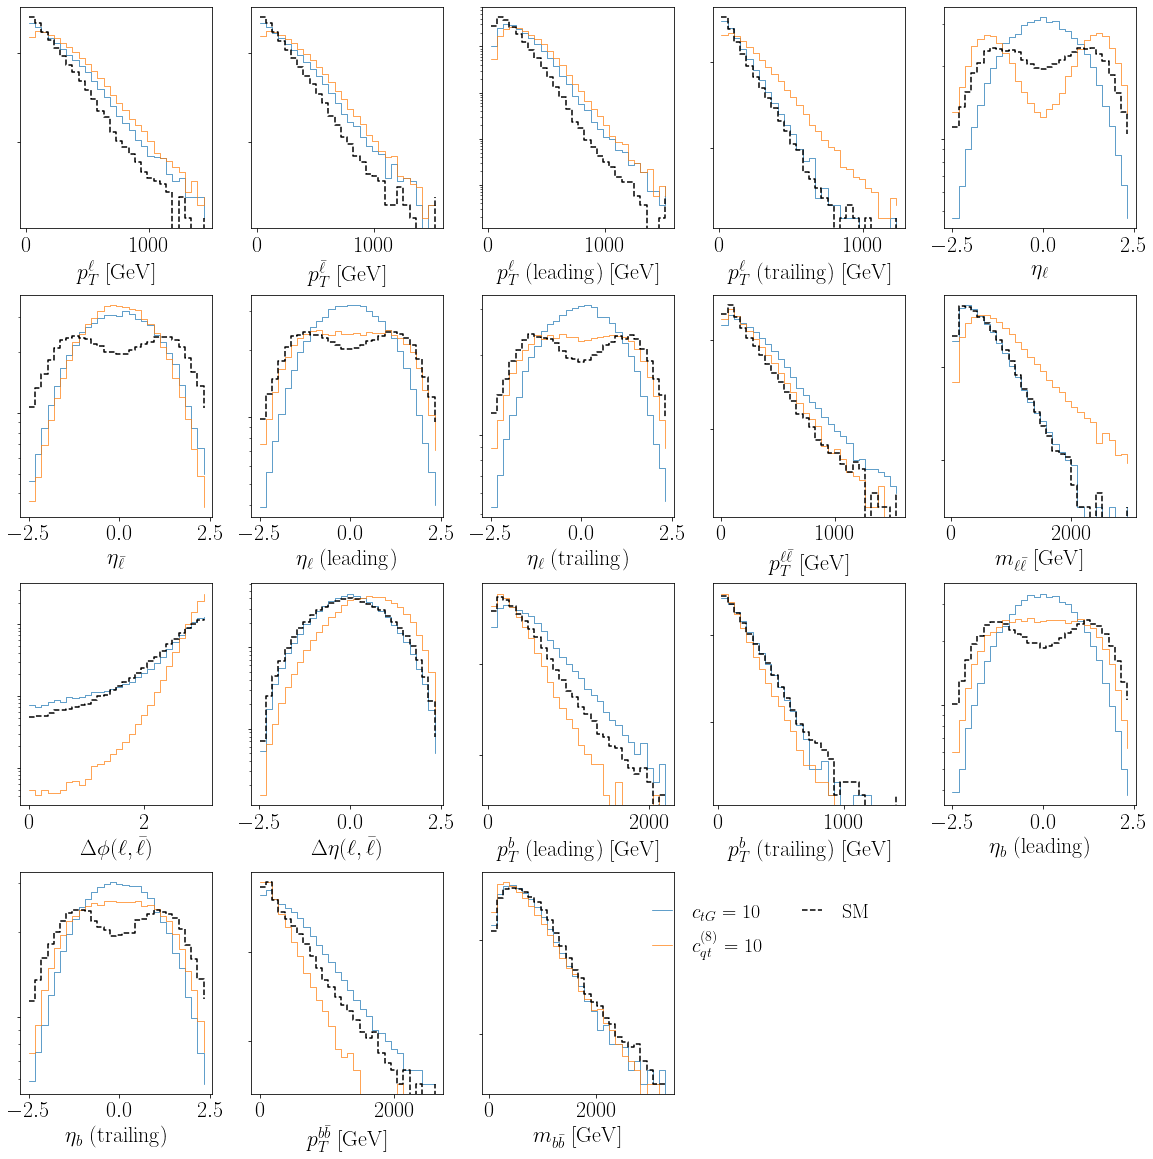

In [6]:
fig = features.plot_features(events_sm, events_eft, feature_dict, legend_labels);

Looking at the distribution of the 18 features plotted above, we notice some clear departures away from the SM in nearly all kinematic features. We thus expect a full multivariate analysis to pay off compared to a simple binned analysis in one or two kinematics. The latter is also inherently bound by the curse of dimensionality: a binned analysis would require populating a 18-dim feature space through Monte Carlo, which is simply impossible since the number of simulated events required to populate a 18-dim feature space scales exponentially with the number of dimensions!

### Training unbinned observables

Having loaded the training data, we now move on to the actual training part of this introductory tutorial. To this end, we download a training runcard that contains information regarding the setup, such as the architecture, number of mini-batches, epochs and data points, etc...

In [7]:
path_to_runcard = 'https://dl.dropboxusercontent.com/s/v4ulo6icveh63fw/run_card_tt_llvlvlbb.json?dl=0'
runcard = file_downloader(path_to_runcard)

100% [..............................................................] 781 / 781

Let us open the training runcard to see the possible options that can be set

In [8]:
import json

with open(runcard) as json_runcard:
    json_runcard_loaded = json.load(json_runcard)
    
json_runcard_loaded

{'process_id': 'tt',
 'epochs': 2000,
 'lr': 0.0001,
 'n_batches': 50,
 'output_size': 1,
 'hidden_sizes': [100, 100, 100],
 'n_dat': 100000,
 'event_data': './downloads/training_data/',
 'features': ['pt_l1',
  'pt_l2',
  'pt_l_leading',
  'pt_l_trailing',
  'eta_l1',
  'eta_l2',
  'eta_l_leading',
  'eta_l_trailing',
  'pt_ll',
  'm_ll',
  'DeltaPhi_ll',
  'DeltaEta_ll',
  'pt_b_leading',
  'pt_b_trailing',
  'eta_b_leading',
  'eta_b_trailing',
  'pt_bb',
  'm_bb'],
 'loss_type': 'CE',
 'scaler_type': 'robust',
 'patience': 200,
 'val_ratio': 0.2,
 'c_train': {'cQd8': 10,
  'cQj18': 10,
  'cQj38': 10,
  'cQu8': 10,
  'ctd8': 10,
  'ctGRe': -10,
  'ctj8': 10,
  'ctu8': 10}}

The features on which we would like to train can be specified after the ``features`` key. We will train on all available features and keep it as it is. Feel free to change the settings, for instance by following the syntax below

In [9]:
json_runcard_loaded['epochs'] = 200
json_runcard_loaded['lr'] = 0.001
json_runcard_loaded['n_batches'] = 50
json_runcard_loaded['patience'] = 20 # needs to be bigger than number of epochs

In case you have modified some settings, it is important to write them back to the original file:

In [10]:
with open(runcard, 'w') as runcard_updated:
    json.dump(json_runcard_loaded, runcard_updated)

Once you are happy with the settings, the training can be launched as 

In [ ]:
output_dir = './models'
c_name = 'ctGRe'

fitter = classifier.Fitter(json_path = runcard, 
                           mc_run = 0, 
                           c_name = c_name,
                           output_dir = output_dir, 
                           print_log=True)

In this runcard, ``mc_run`` specifies the replica number (must match with ``events_<mc_run>.pkl.gz``), and ``c_name`` denotes the NN that will be trained. Possible options here are for instance ``ctGRe_ctGRe``, ``ctj8_ctj8`` in case of a quadratic coefficient function, or ``ctGRe`` in case one wants to train the linear term in the likelihood ratio accomponying $c_{tG}$.

### Loading models

Trained models can be loaded into an ``Analyse`` object to make them accesible for later use

In [12]:
path_to_models_root = os.path.join('./models', time.strftime("%Y/%m/%d"))
order = 'lin' # or quad when quadratic models have been trained

models_paths_dict = analyse.Analyse.build_path_dict(root=path_to_models_root,
                        order=order,
                        prefix='model')

analyser = analyse.Analyse(models_paths_dict, order, all=True)

The loss profile of the models we have just trained can be plotted via

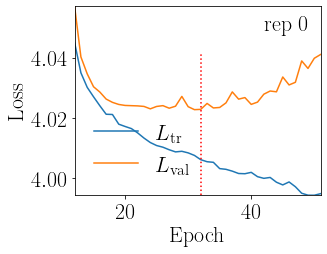

In [18]:
fig, _ = analyser.plot_loss_overview(c_name, order, xlim=12)

### Pretrained models

Since properly training models takes a bit of time, we have provided a set of pretrained models that can be directly loaded and analysed. We consider the 2 feature case applied to $p_T^{\ell\bar{\ell}}$ and $\eta_\ell$ first.

In [ ]:
models_2_feat_url = 'https://dl.dropboxusercontent.com/s/dy7ni8t4g8x68u0/tt_particle_ptll_etal.tar.gz?dl=0'
pretrained_models_2_feat = file_downloader(models_2_feat_url);
untar(pretrained_models_2_feat, destination='./downloads/models/tt_llvlvlbb_2_feat');

Like before, we load the models into a ``Analyse`` object:

In [20]:
path_to_models_2_feat_root = './downloads/models/tt_llvlvlbb_2_feat'
order = 'quad'

models_paths_dict_2_feat = analyse.Analyse.build_path_dict(root=path_to_models_2_feat_root,
                        order=order,
                        prefix='model')

analyser_2_feat = analyse.Analyse(models_paths_dict_2_feat, order)

Given some "observed" data (not used during training) drawn from the SM, we can evaluate the NNs on this data through the following syntax:

In [ ]:
observed_data_url = 'https://dl.dropboxusercontent.com/s/igjt97vfaxdn9y1/events_0.pkl.gz?dl=0'
observed_data = file_downloader(observed_data_url, './downloads/observed_data');

events_sm, _ = analyse.Analyse.load_events('./downloads/observed_data/events_0.pkl.gz')

# evaluate pretrained NNs on observed data
analyser_2_feat.evaluate_models(events_sm)

The output of all NN replicas for all coefficients is stored inside a pandas dataframe that can be called like

In [22]:
models_evaluated_2_feat = analyser_2_feat.models_evaluated_df;

To see for instance the output associated to the NN associated to $c_{tG}$ at the linear level, one can run

In [23]:
models_evaluated_2_feat['models']['lin', 'ctGRe'];

Let us finally plot the (median) $\mathrm{NN}^{c_{tG}}$ as a 2-dimensional surface in the 2-dim feature space $(p_{T}^{\ell, \bar{\ell}}, \eta_\ell)$:

In [24]:
# create the 2-dim grid in feature space
eta_l_span = np.linspace(-2.5, 2.5, 100)
pt_ll_span = np.linspace(0, 450, 50)
eta_l_grid, pt_ll_grid = np.meshgrid(eta_l_span, pt_ll_span)
grid = np.c_[eta_l_grid.ravel(), pt_ll_grid.ravel()]
df = pd.DataFrame({'pt_ll': grid[:, 1], 'eta_l1': grid[:, 0]})

# evaluate the NNs on this grid and 
analyser_2_feat.evaluate_models(df)
models_evaluated = analyser_2_feat.models_evaluated_df['models']
analyser_2_feat.models_evaluated_df['models'] = models_evaluated.apply(lambda row: np.median(row, axis=0))

nn_ctG = analyser_2_feat.models_evaluated_df['models']['lin', 'ctGRe'].reshape(eta_l_grid.shape)

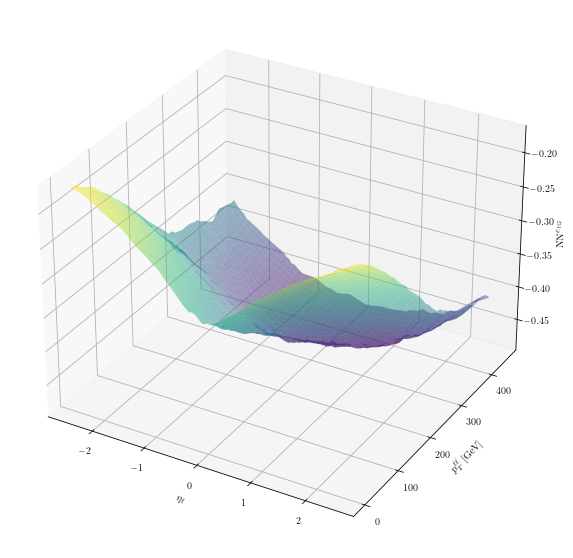

In [25]:
# make a 3D interactive plot
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel(r'$\eta_\ell$')
ax.set_ylabel(r'$p_T^{\ell\bar{\ell}}\;\mathrm{[GeV]}$')
ax.set_zlabel(r'$\mathrm{NN}^{c_{tG}}$')
ax.plot_surface(eta_l_grid, pt_ll_grid, nn_ctG, cmap='viridis', alpha=0.5)

### 18 features

The fully multivariate models are also available, and can be loaded exactly like before

In [ ]:
# download the models 
models_18_feat_url = 'https://dl.dropboxusercontent.com/s/xu6o2fxqtw6l8e9/tt_particle_18_feat.tar.gz?dl=0'
pretrained_models_18_feat = file_downloader(models_18_feat_url);
untar(pretrained_models_18_feat, destination='./downloads/models/tt_llvlvlbb_18_feat');

In [ ]:
# load the models
path_to_models_18_feat_root = './downloads/models/tt_llvlvlbb_18_feat'
order = 'quad'

models_paths_dict_18_feat = analyse.Analyse.build_path_dict(root=path_to_models_18_feat_root,
                        order=order,
                        prefix='model')

analyser_18_feat = analyse.Analyse(models_paths_dict_18_feat, order)

In [ ]:
# evaluate pretrained NNs on observed data
analyser_18_feat.evaluate_models(events_sm)

In [ ]:
analyser_18_feat.models_evaluated_df;

In [ ]:
models_evaluated_18_feat = analyser_18_feat.models_evaluated_df['models']

In [ ]:
models_evaluated_18_feat['lin', 'ctGRe'];